In [1]:
import numpy as np
import matplotlib.pyplot as plt
import imageio
import random

In [2]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [3]:
def unify(board):
    b= np.copy(board)
    b[board == 96] = 5
    b[board == 117] = 1
    b[board == 158] = 2
    b[board == 185] = 3
    b[board == 255] = 4
    return b

In [4]:
class Env:
    def __init__(self,name):
        maze = imageio.imread('maze.png',pilmode='L')
        maze_with_acid = imageio.imread('maze_with_acid.png',pilmode='L')
        maze_with_acid_with_door = imageio.imread('maze_with_acid_with_door.png',pilmode='L')
        
        maze = unify(maze)
        maze_with_acid = unify(maze_with_acid)
        maze_with_acid_with_door = unify(maze_with_acid_with_door)
        
        self.door = False
        if name is 'normal':
            self.default_board = np.copy(maze)
            self.board = np.copy(maze)
        elif name is 'acid':
            self.default_board = np.copy(maze_with_acid)
            self.board = np.copy(maze_with_acid)
        elif name is 'door':
            self.door = True
            self.default_board = np.copy(maze_with_acid_with_door)
            self.board = np.copy(maze_with_acid_with_door)
        else:
            raise Exception('invalid env') 
            
            
        android_cords = np.where(self.board == 1)
        android_cords = (android_cords[0][0],android_cords[1][0])
        android_cords
        
        start_cords = np.where(self.board == 2)
        start_cords = (start_cords[0][0],start_cords[1][0])
        start_cords
            
        self.door_key_not_used = True
        self.target = np.array(android_cords)
        if self.door:
            self.state_start = np.array((*start_cords,0))
            self.state = np.array((*start_cords,0))
        else:
            self.state_start = np.array(start_cords)
            self.state = np.array(start_cords)
        
        if self.door:
            self.action_space = 5
        else:
            self.action_space = 4
            
        if self.door:
            self.observation_space = (*self.board.shape,2)
        else:
            self.observation_space = self.board.shape
        
        # 0 => up 1 => right 2 => down 3 => left 4 => use key
        if self.door:
            self.__move_fun = {0:np.array((0,1,0)),1:np.array((1,0,0)),2:np.array((0,-1,0)),3:np.array((-1,0,0)),4:np.array((0,0,1))}
        else:
            self.__move_fun = {0:np.array((0,1)),1:np.array((1,0)),2:np.array((0,-1)),3:np.array((-1,0)),4:np.array((0,0))}
        
    
    def reset(self):
        self.board = np.copy(self.default_board)
        self.state = self.state_start
        return tuple(self.state)
    
        
    def step(self,action):
        done = False
        reward = -1
        new_state = self.state + self.__move_fun[action]
        s = tuple(new_state[:2])
        if self.board[s] == 0 or self.board[s] == 5:
            new_state = self.state
        elif self.board[s] == 1:
            done = True
            reward = 500
        elif self.board[s] == 3:
            done = True
            reward = -500
            
        if action == 4 and self.door_key_not_used and self.door:
            state_area = self.board[(s[0]-5):(s[0]+5),(s[1]-5):(s[1]+5)]
            state_area[state_area == 5] = 4 #florify
            reward = 0
            new_state[-1] = 1
            self.door_key_not_used = False
            
        self.state = new_state
            
        return tuple(new_state), reward, done
        
    def sample(self):
        if self.door_key_not_used and self.door:
            mod = -1
        else:
            mod = -2
        return random.randint(0,self.action_space + mod)
    


In [5]:
def train_agent_Q(env,props,door=False):
    rewards = []
    rewards_sum = []
    action_size = env.action_space
    state_size = env.observation_space
    qtable = np.zeros((*state_size, action_size))
    
    total_episodes = props['total_episodes']
    learning_rate = props['learning_rate']
    max_steps = props['max_steps']
    gamma = props['gamma']
    epsilon = props['epsilon']
    max_epsilon = props['max_epsilon']
    min_epsilon = props['min_epsilon']
    decay_rate = props['decay_rate']
        
    for episode in range(total_episodes):
        
        update_progress(episode/total_episodes)
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        key_used = False

        for step in range(max_steps):
            exp_exp_tradeoff = random.uniform(0, 1)
            if exp_exp_tradeoff > epsilon:
                if key_used:
                    action = np.argmax(qtable[state][:4])
                else:
                    action = np.argmax(qtable[state])
            else:
                action = env.sample()

            if action == 4:
                key_used = True

            new_state, reward, done = env.step(action)
            qtable[state][action] = qtable[state][action] + learning_rate * (reward + gamma * np.max(qtable[new_state]) - qtable[state][action])

            total_rewards += reward
            state = new_state
            
            if done == True: 
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
        rewards.append(total_rewards)
        rewards_sum.append(sum(rewards)/(episode+1))
    return rewards,rewards_sum,qtable

In [6]:
def move_agent_Q(env,props,n,table=None):
    action_size = env.action_space
    state_size = env.observation_space
    qtable = np.zeros((*state_size, action_size)) if table is None else table
    prob = np.zeros(state_size)
    epsilon = props['min_epsilon'] if table is not None else props['max_epsilon']
    max_steps=props['max_steps']
    for episode in range(n):
        update_progress(episode/n)
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        key_used = False

        for step in range(max_steps):
            exp_exp_tradeoff = random.uniform(0, 1)
            if exp_exp_tradeoff > epsilon:
                if key_used:
                    action = np.argmax(qtable[state][:4])
                else:
                    action = np.argmax(qtable[state])
            else:
                action = env.sample()

            if action == 4:
                key_used = True
                
            new_state, _, done = env.step(action)
            prob[state] += 1
            state = new_state
            if done == True: 
                break
                
    return prob/n

In [7]:
def train_agent_Sarsa(env,props,door=False):
    rewards = []
    rewards_sum = []
    action_size = env.action_space
    state_size = env.observation_space
    qtable = np.zeros((*state_size, action_size))
    
    total_episodes = props['total_episodes']
    learning_rate = props['learning_rate']
    max_steps = props['max_steps']
    gamma = props['gamma']
    epsilon = props['epsilon']
    max_epsilon = props['max_epsilon']
    min_epsilon = props['min_epsilon']
    decay_rate = props['decay_rate']
        
    for episode in range(total_episodes):
        
        update_progress(episode/total_episodes)
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        key_used = False
        
        exp_exp_tradeoff = random.uniform(0, 1)
        if exp_exp_tradeoff > epsilon:
            if key_used:
                action = np.argmax(qtable[new_state][:4])
            else:
                action = np.argmax(qtable[new_state])
        else:
            action = env.sample()

        for step in range(max_steps):
            if action == 4:
                key_used = True

            new_state, reward, done = env.step(action)

            exp_exp_tradeoff = random.uniform(0, 1)
            if exp_exp_tradeoff > epsilon:
                if key_used:
                    action_2 = np.argmax(qtable[new_state][:4])
                else:
                    action_2 = np.argmax(qtable[new_state])
            else:
                action_2 = env.sample()

            qtable[state][action] = qtable[state][action] + learning_rate * (reward + gamma * qtable[new_state][action_2] - qtable[state][action])

            total_rewards += reward
            state = new_state
            action=action_2
            
            if done == True: 
                break

        epsilon = min_epsilon + (max_epsilon - min_epsilon)*np.exp(-decay_rate*episode) 
        rewards.append(total_rewards)
        rewards_sum.append(sum(rewards)/(episode+1))
    return rewards,rewards_sum,qtable

In [8]:
def move_agent_sarsa(env,props,n,table=None):
    action_size = env.action_space
    state_size = env.observation_space
    qtable = np.zeros((*state_size, action_size)) if table is None else table
    prob = np.zeros(state_size)
    epsilon = props['min_epsilon'] if table is not None else props['max_epsilon']
    max_steps=props['max_steps']
    exp_exp_tradeoff = random.uniform(0, 1)
    key_used = False
    
    
    state = env.reset()
    if exp_exp_tradeoff > epsilon:
        if key_used:
            action = np.argmax(qtable[state][:4])
        else:
            action = np.argmax(qtable[state])
    else:
        action = env.sample()
    for episode in range(n):
        update_progress(episode/n)
        state = env.reset()
        step = 0
        done = False
        total_rewards = 0
        key_used = False

        for step in range(max_steps):
            new_state, _, done = env.step(action)
            exp_exp_tradeoff = random.uniform(0, 1)
            if exp_exp_tradeoff > epsilon:
                if key_used:
                    action_2 = np.argmax(qtable[new_state][:4])
                else:
                    action_2 = np.argmax(qtable[new_state])
            else:
                action_2 = env.sample()

            if action == 4:
                key_used = True

            prob[state] += 1
            state = new_state
            action=action_2
            if done == True: 
                break
                
    return prob/n

In [9]:
def print_route(env,qtable):
    route = np.copy(env.board)
    state = env.reset()
    step = 0
    done = False
    plt.figure(figsize=(10,10))
    for step in range(max_steps):
        action = np.argmax(qtable[state])
        route[state] = 2 # color the path
        new_state, reward, done = env.step(action)
        if done:
            if np.all(new_state == env.target):
                print("Netrunner has reached android 🏆")
            else:
                print("Netrunner has failed ☠️")
            print("Number of steps", step)
            break
        state = new_state
    plt.imshow(route)
    plt.show()

# No acid maze

In [10]:
env = Env('normal')

Start point: [58 25] Target: [14 41]


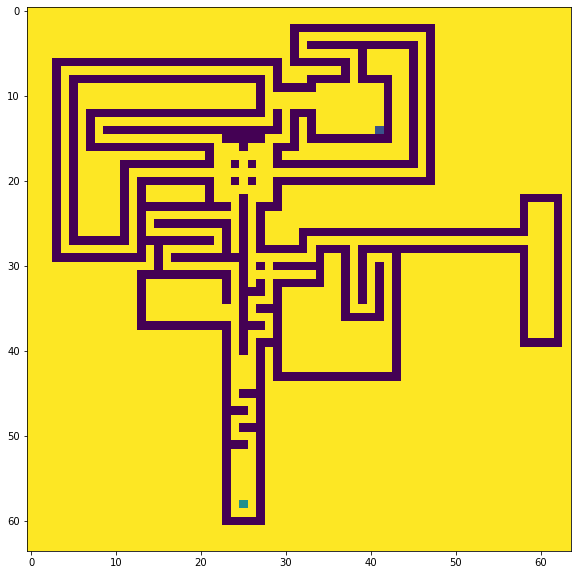

In [11]:
print(f'Start point: {env.state_start} Target: {env.target}')
plt.figure(figsize=(10,10))
plt.imshow(env.board)
plt.show()

In [12]:
props = {
'total_episodes' : 10000,
'learning_rate' : 0.7,
'max_steps' : 400,
'gamma' : 0.95,
'epsilon' : 1.0,
'max_epsilon' : 1.0,
'min_epsilon' : 0.01,
'decay_rate' : 0.005
}
max_steps=props['max_steps']

# Q-learning

In [13]:
rewards,rewards_sum,qtable = train_agent_Q(env,props)

Progress: [####################] 100.0%


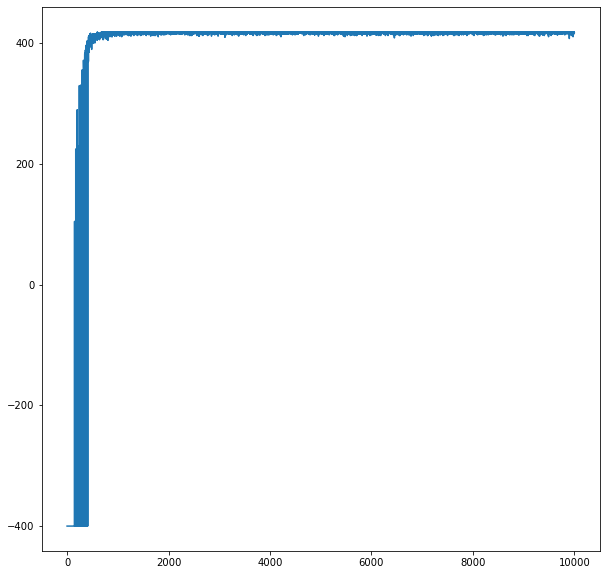

In [14]:
plt.figure(figsize=(10,10))
plt.plot(rewards)

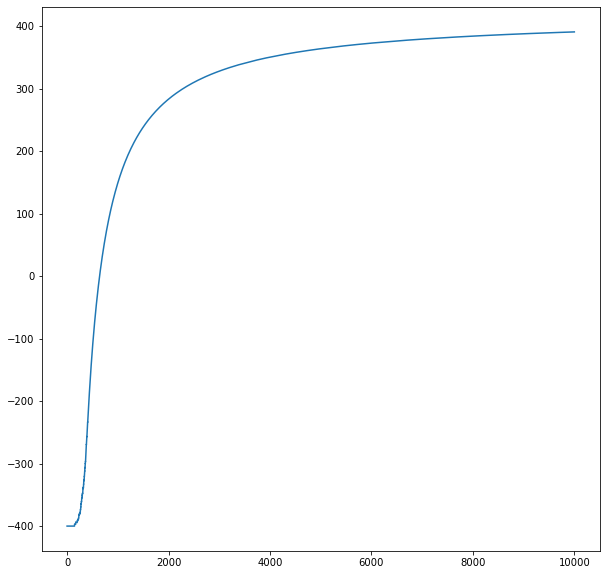

In [15]:
plt.figure(figsize=(10,10))
plt.plot(rewards_sum)

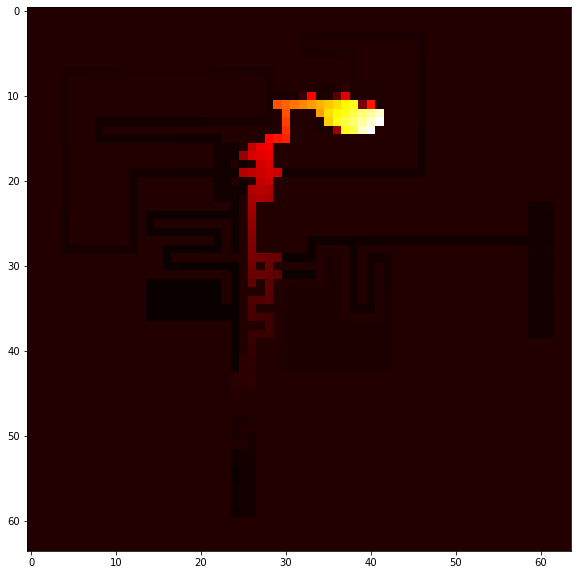

In [16]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(qtable,axis=2),cmap='hot')

In [17]:
prob_1=move_agent_Q(env,props,1000)

Progress: [####################] 99.9%


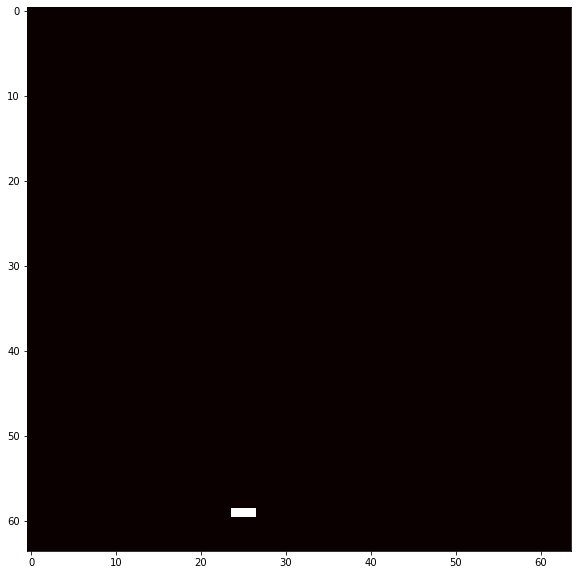

In [18]:
plt.figure(figsize=(10,10))
plt.imshow(prob_1,cmap='hot')

In [19]:
prob_2=move_agent_Q(env,props,1000,qtable)

Progress: [####################] 99.9%


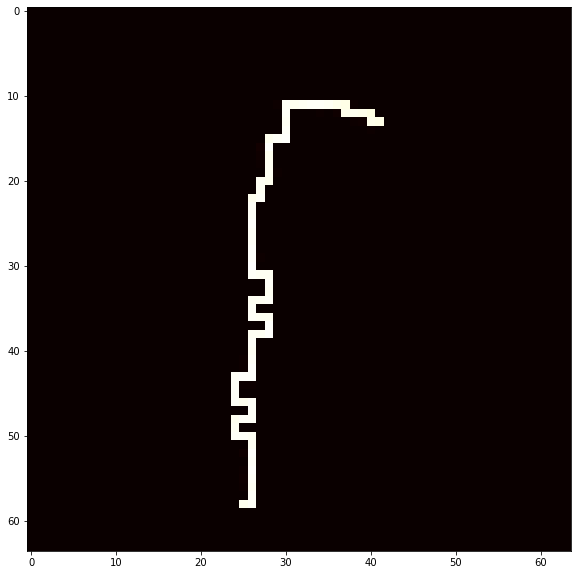

In [20]:
plt.figure(figsize=(10,10))
plt.imshow(prob_2,cmap='hot')

Netrunner has reached android 🏆
Number of steps 81


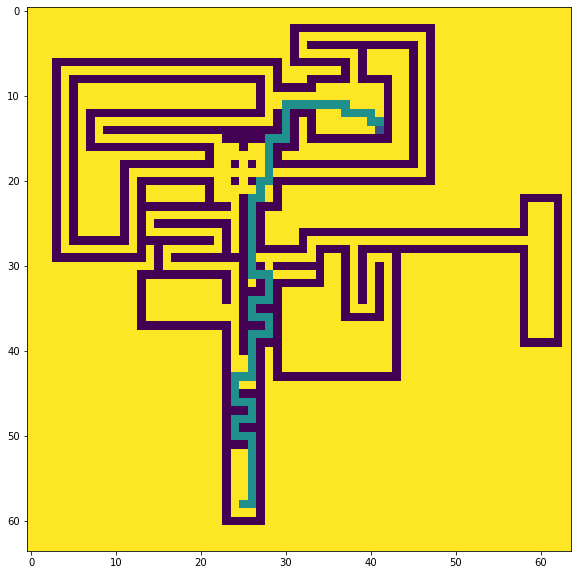

In [21]:
print_route(env,qtable)

# Modified Props

In [22]:
props = {
'total_episodes' : 10000,
'learning_rate' : 0.5,
'max_steps' : 400,
'gamma' : 0.90,
'epsilon' : 1.0,
'max_epsilon' : 1.0,
'min_epsilon' : 0.01,
'decay_rate' : 0.4
}

In [23]:
env = Env('normal')

In [24]:
rewards,rewards_sum,qtable = train_agent_Q(env,props)

Progress: [####################] 100.0%


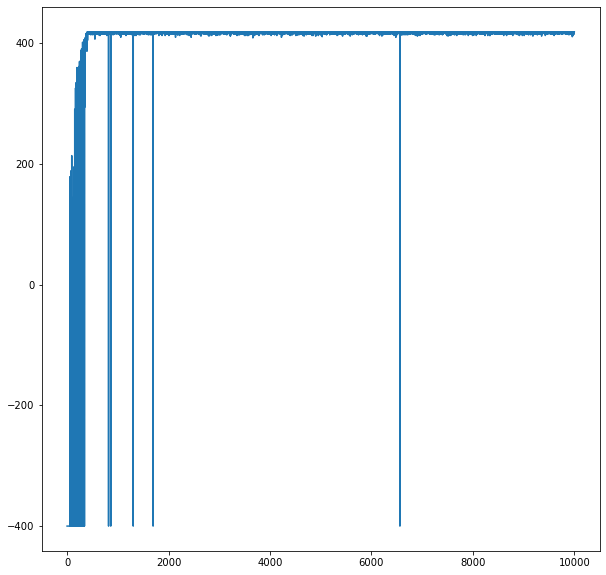

In [25]:
plt.figure(figsize=(10,10))
plt.plot(rewards)

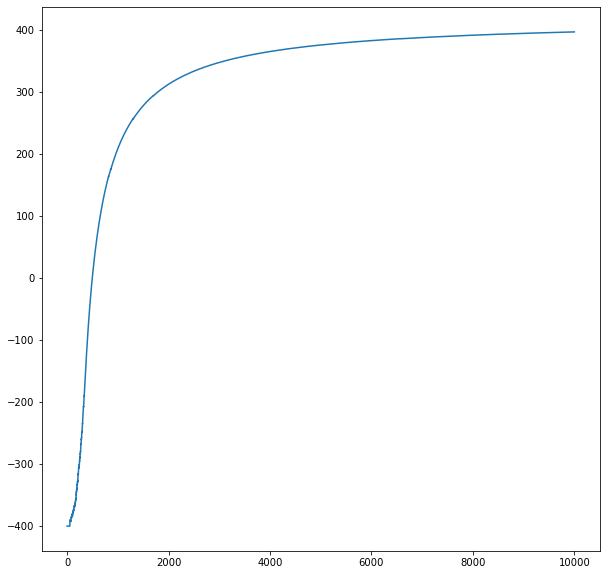

In [26]:
plt.figure(figsize=(10,10))
plt.plot(rewards_sum)

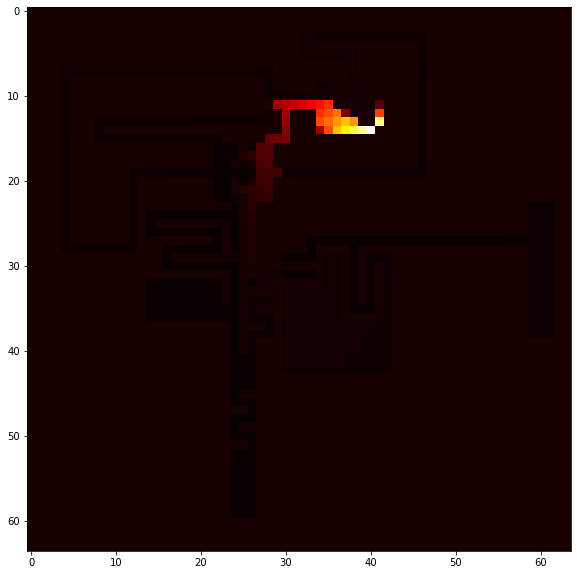

In [27]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(qtable,axis=2),cmap='hot')

In [28]:
prob_1=move_agent_Q(env,props,1000)

Progress: [####################] 99.9%


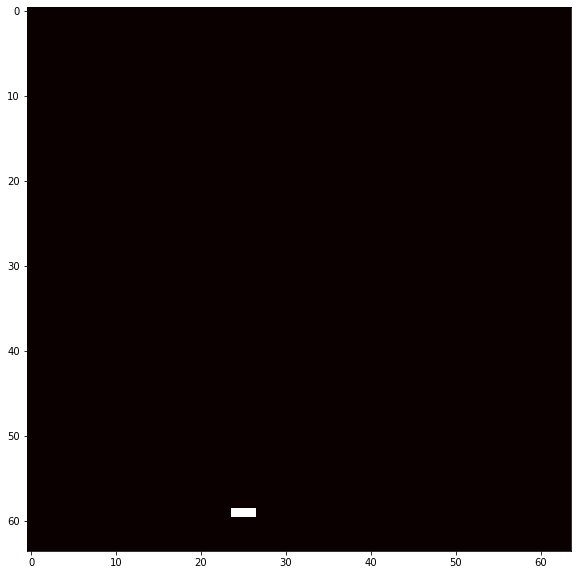

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(prob_1,cmap='hot')

In [30]:
prob_2=move_agent_Q(env,props,1000,qtable)

Progress: [####################] 99.9%


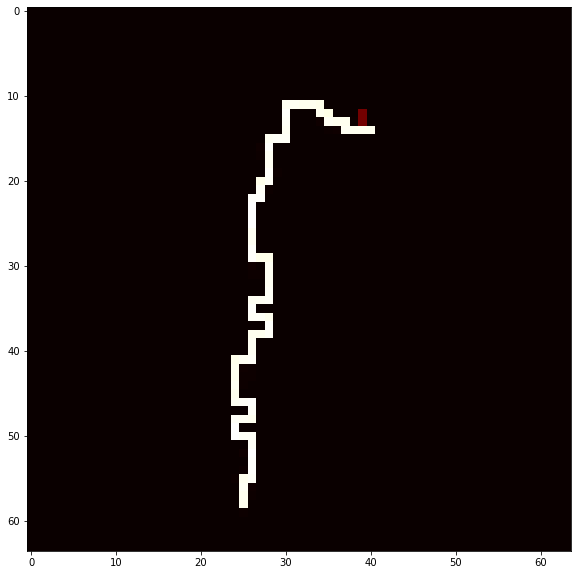

In [31]:
plt.figure(figsize=(10,10))
plt.imshow(prob_2,cmap='hot')

Netrunner has reached android 🏆
Number of steps 81


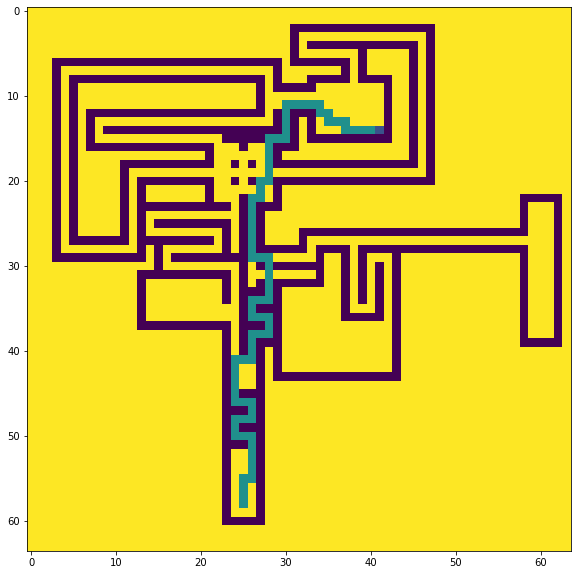

In [32]:
print_route(env,qtable)

# Modified Props 2

In [33]:
props = {
'total_episodes' : 10000,
'learning_rate' : 0.5,
'max_steps' : 400,
'gamma' : 0.40,
'epsilon' : 1.0,
'max_epsilon' : 1.0,
'min_epsilon' : 0.01,
'decay_rate' : 0.4
}

In [34]:
env = Env('normal')

In [35]:
rewards,rewards_sum,qtable = train_agent_Q(env,props)

Progress: [####################] 100.0%


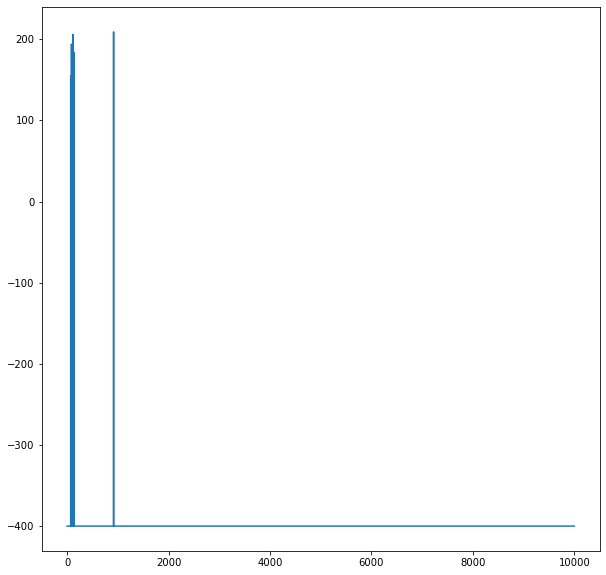

In [36]:
plt.figure(figsize=(10,10))
plt.plot(rewards)

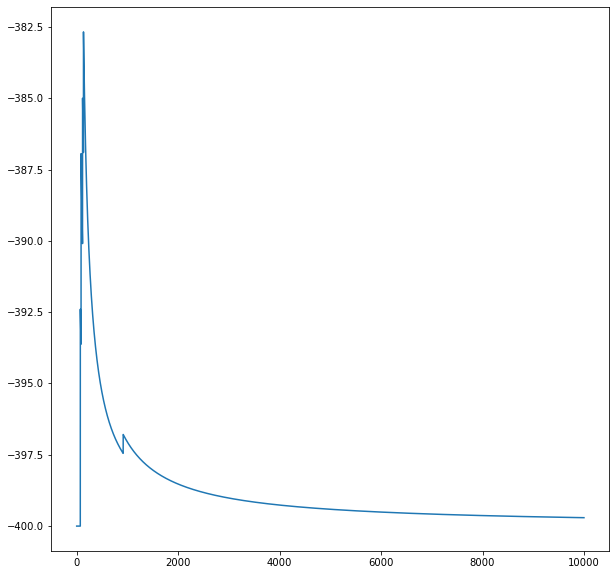

In [37]:
plt.figure(figsize=(10,10))
plt.plot(rewards_sum)

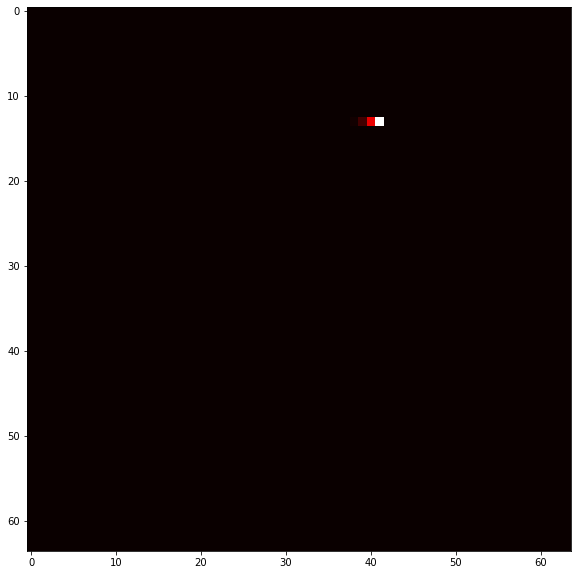

In [38]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(qtable,axis=2),cmap='hot')

In [39]:
prob_1=move_agent_Q(env,props,1000)

Progress: [####################] 99.9%


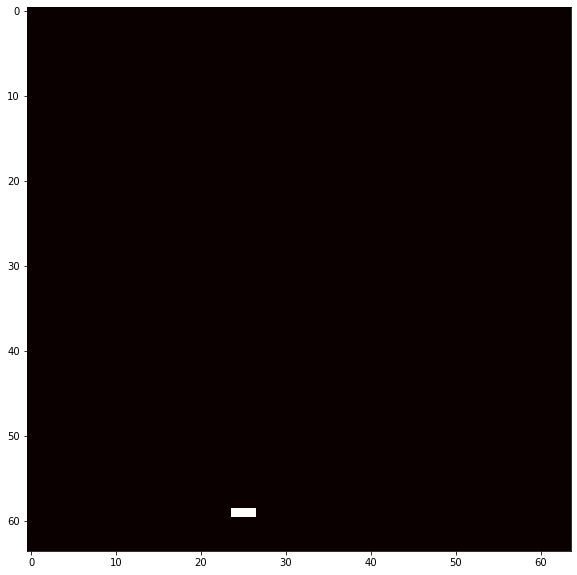

In [40]:
plt.figure(figsize=(10,10))
plt.imshow(prob_1,cmap='hot')

In [41]:
prob_2=move_agent_Q(env,props,1000,qtable)

Progress: [####################] 99.9%


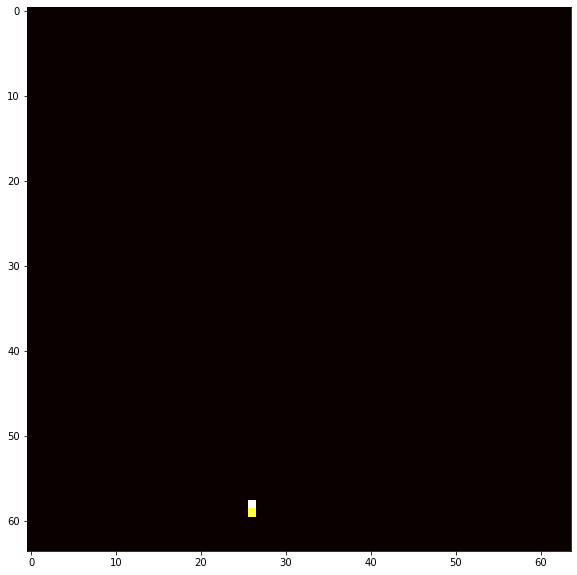

In [42]:
plt.figure(figsize=(10,10))
plt.imshow(prob_2,cmap='hot')

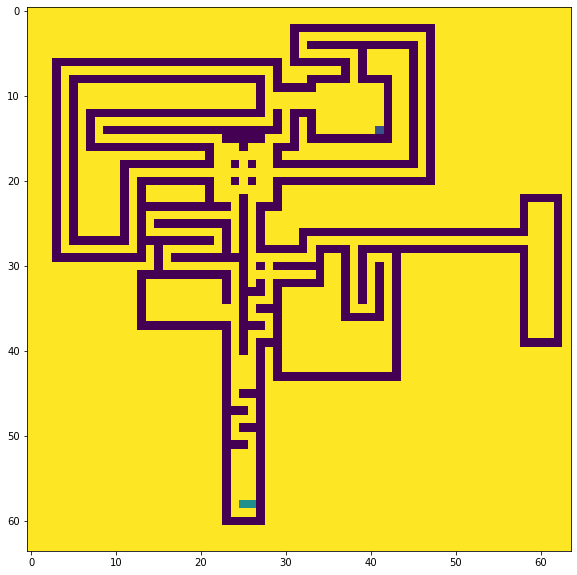

In [43]:
print_route(env,qtable)

# SARSA

In [44]:
props = {
'total_episodes' : 10000,
'learning_rate' : 0.7,
'max_steps' : 800,
'gamma' : 0.95,
'epsilon' : 1.0,
'max_epsilon' : 1.0,
'min_epsilon' : 0.01,
'decay_rate' : 0.005
}

In [45]:
rewards,rewards_sum,qtable = train_agent_Sarsa(env,props)

Progress: [####################] 100.0%


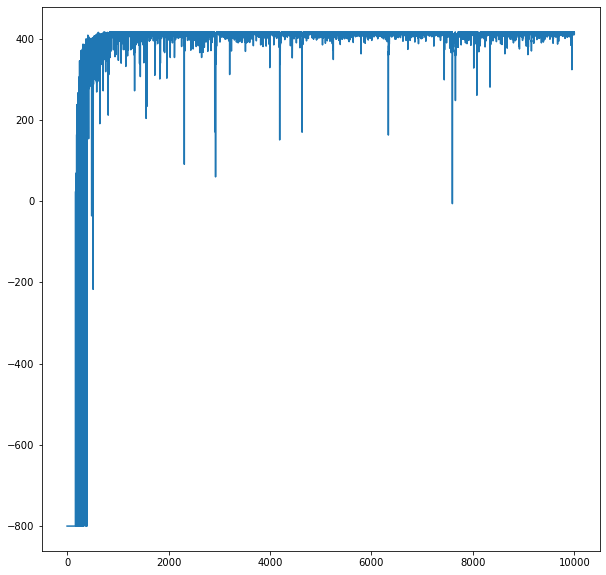

In [46]:
plt.figure(figsize=(10,10))
plt.plot(rewards)

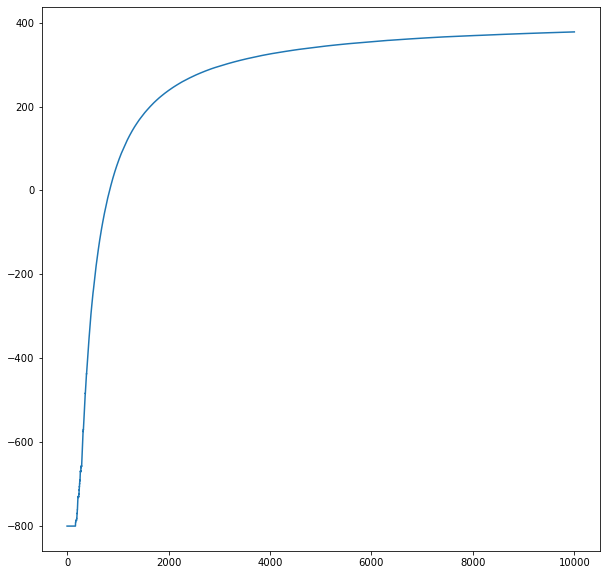

In [47]:
plt.figure(figsize=(10,10))
plt.plot(rewards_sum)

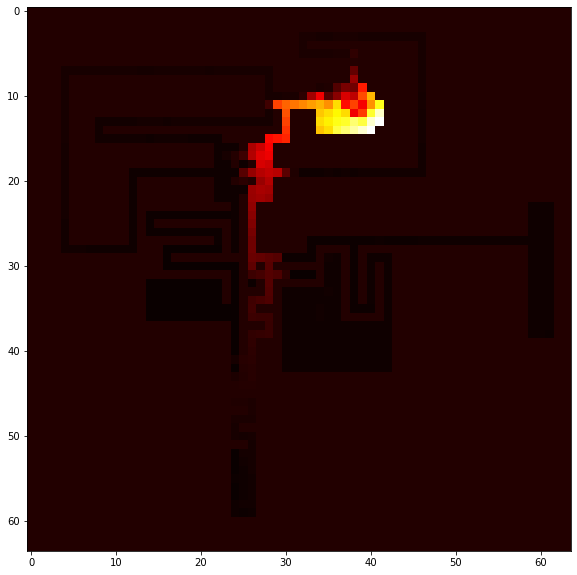

In [48]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(qtable,axis=2),cmap='hot')

In [49]:
prob_1=move_agent_sarsa(env,props,1000)

Progress: [####################] 99.9%


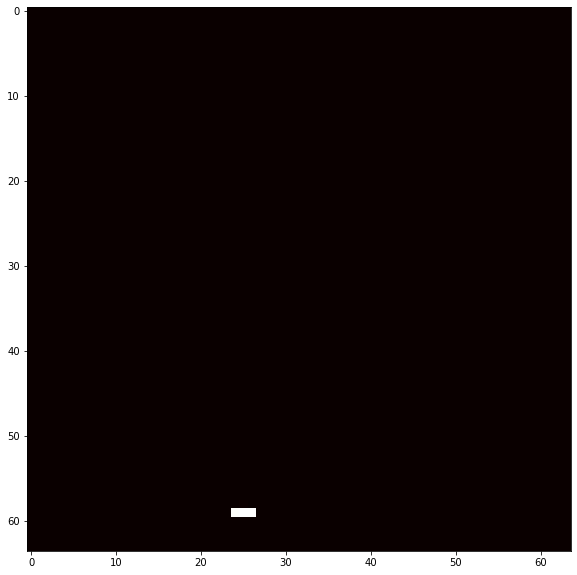

In [50]:
plt.figure(figsize=(10,10))
plt.imshow(prob_1,cmap='hot')

In [51]:
prob_2=move_agent_sarsa(env,props,1000,qtable)

Progress: [####################] 99.9%


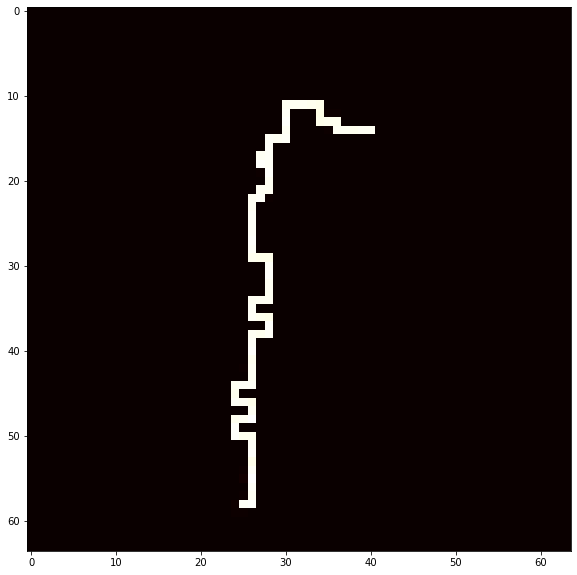

In [52]:
plt.figure(figsize=(10,10))
plt.imshow(prob_2,cmap='hot')

Netrunner has reached android 🏆
Number of steps 83


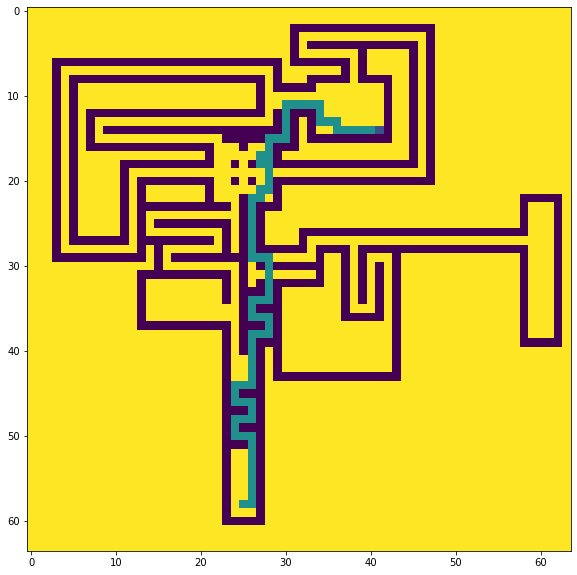

In [53]:
print_route(env,qtable)

# Acid maze

In [54]:
env = Env('acid')

Start point: [58 25] Target: [14 41]


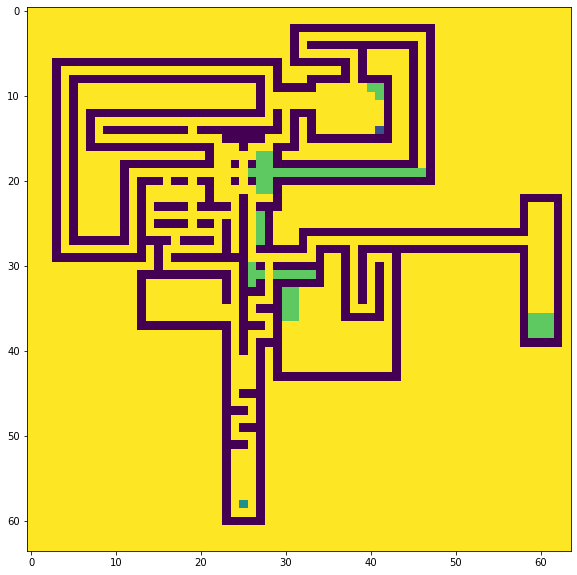

In [55]:
print(f'Start point: {env.state_start} Target: {env.target}')
plt.figure(figsize=(10,10))
plt.imshow(env.board)
plt.show()

In [56]:
props = {
'total_episodes' : 15000,
'learning_rate' : 0.7,
'max_steps' : 400,
'gamma' : 0.95,
'epsilon' : 1.0,
'max_epsilon' : 1.0,
'min_epsilon' : 0.01,
'decay_rate' : 0.005
}
max_steps=props['max_steps']

In [57]:
rewards,rewards_sum,qtable = train_agent_Q(env,props)

Progress: [####################] 100.0%


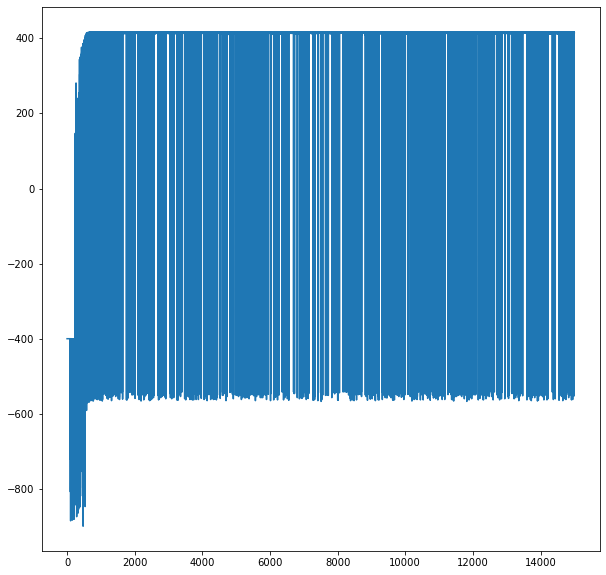

In [58]:
plt.figure(figsize=(10,10))
plt.plot(rewards)

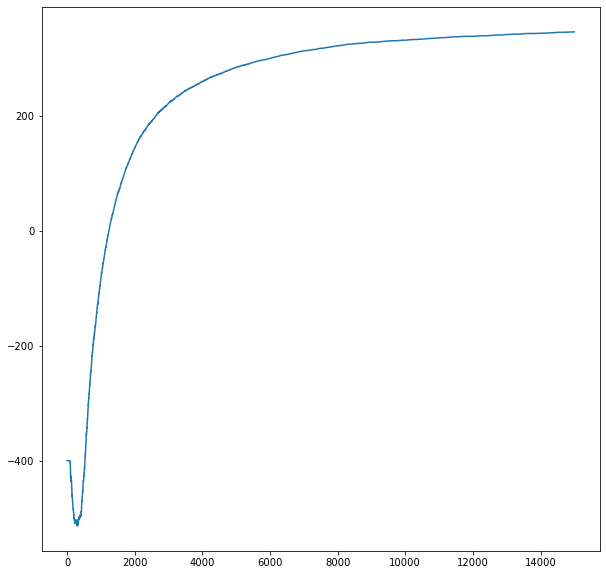

In [59]:
plt.figure(figsize=(10,10))
plt.plot(rewards_sum)

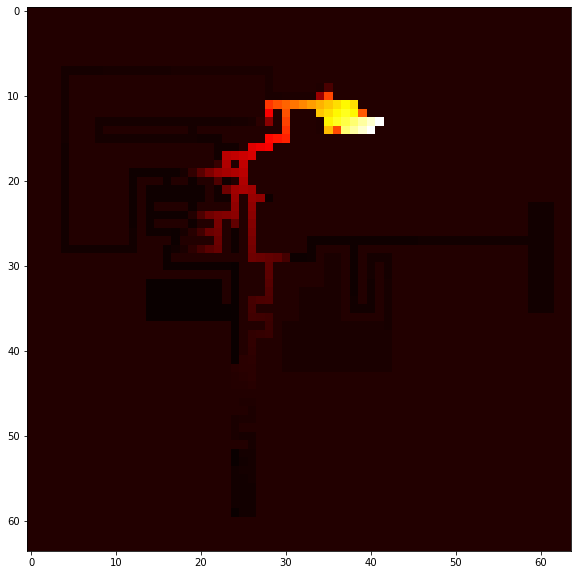

In [60]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(qtable,axis=2),cmap='hot')

In [61]:
prob_1=move_agent_Q(env,props,1000)

Progress: [####################] 99.9%


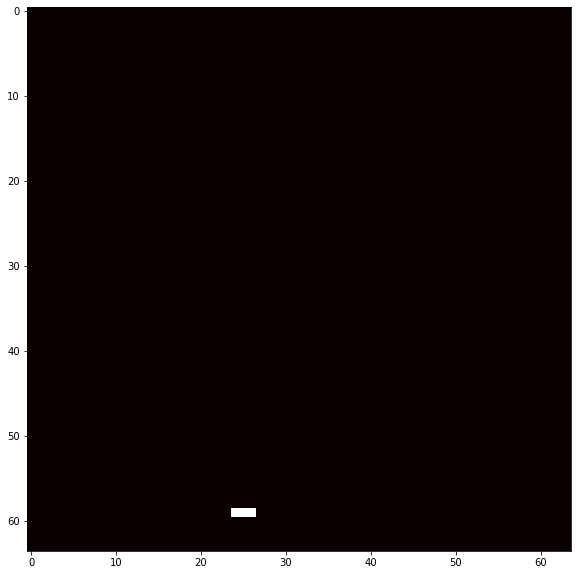

In [62]:
plt.figure(figsize=(10,10))
plt.imshow(prob_1,cmap='hot')

In [63]:
prob_2=move_agent_Q(env,props,1000,qtable)

Progress: [####################] 99.9%


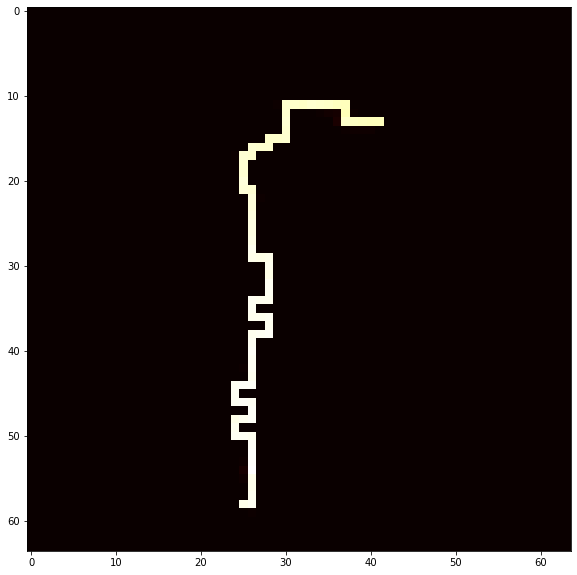

In [64]:
plt.figure(figsize=(10,10))
plt.imshow(prob_2,cmap='hot')

Netrunner has reached android 🏆
Number of steps 83


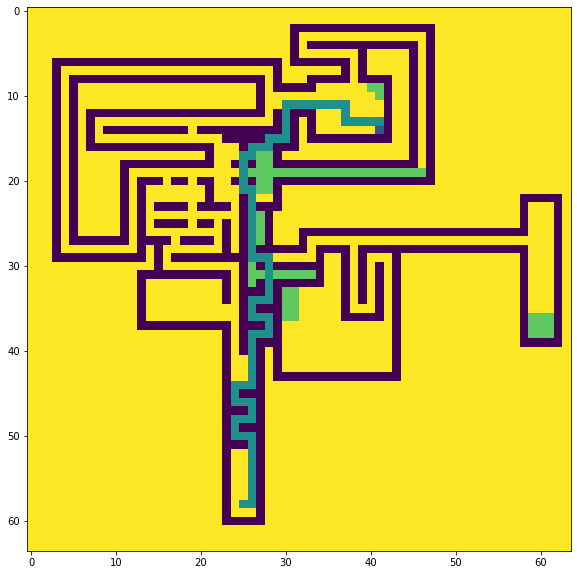

In [65]:
print_route(env,qtable)

# SARSA

In [66]:
props = {
'total_episodes' : 15000,
'learning_rate' : 0.7,
'max_steps' : 800,
'gamma' : 0.98,
'epsilon' : 1.0,
'max_epsilon' : 1.0,
'min_epsilon' : 0.01,
'decay_rate' : 0.005
}
max_steps=props['max_steps']

In [67]:
rewards,rewards_sum,qtable = train_agent_Sarsa(env,props)

Progress: [####################] 100.0%


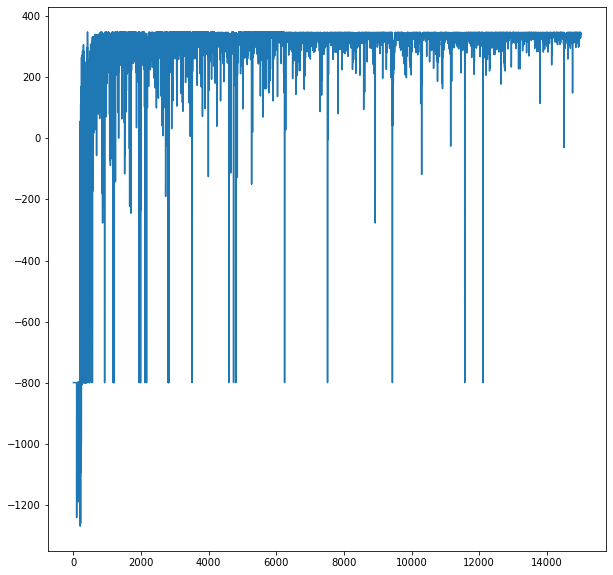

In [68]:
plt.figure(figsize=(10,10))
plt.plot(rewards)

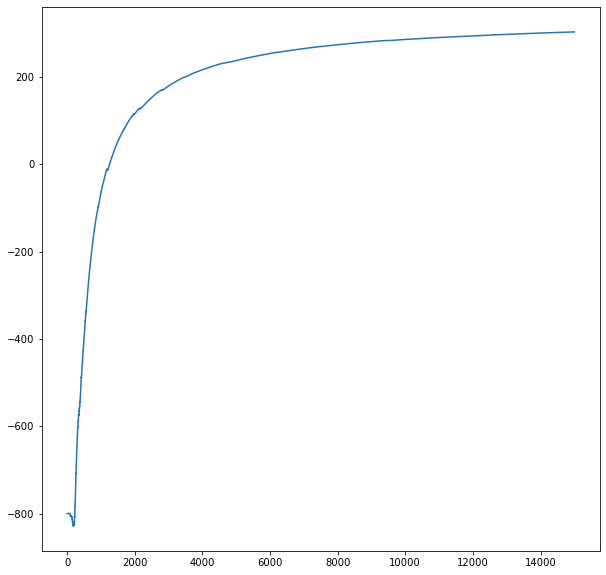

In [69]:
plt.figure(figsize=(10,10))
plt.plot(rewards_sum)

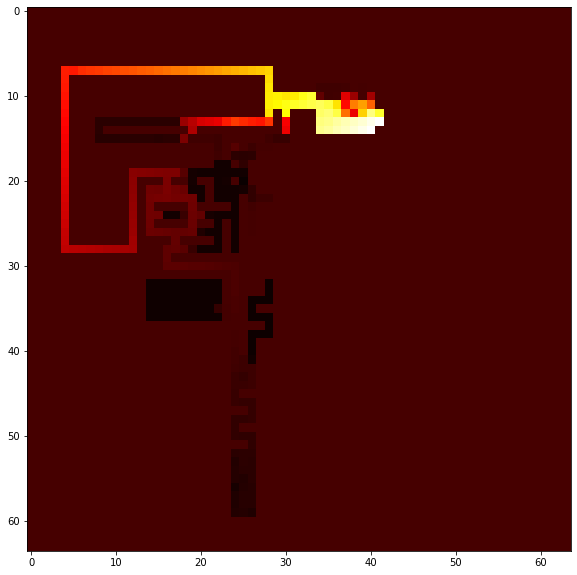

In [70]:
plt.figure(figsize=(10,10))
plt.imshow(np.max(qtable,axis=2),cmap='hot')

In [71]:
prob_1=move_agent_sarsa(env,props,1000)

Progress: [####################] 99.9%


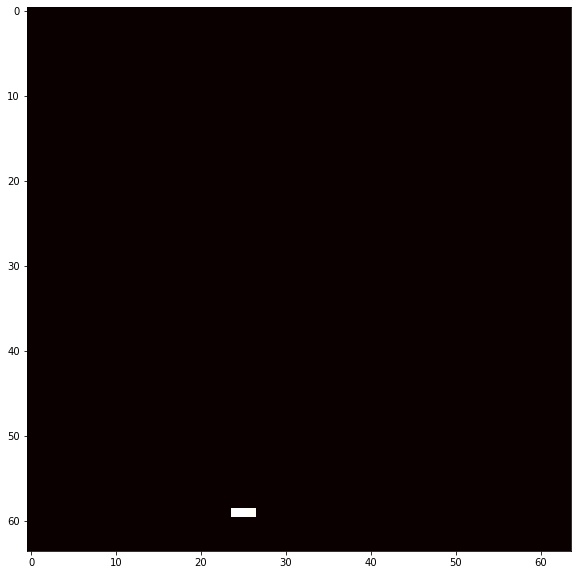

In [72]:
plt.figure(figsize=(10,10))
plt.imshow(prob_1,cmap='hot')

In [73]:
prob_2=move_agent_sarsa(env,props,1000,qtable)

Progress: [####################] 99.9%


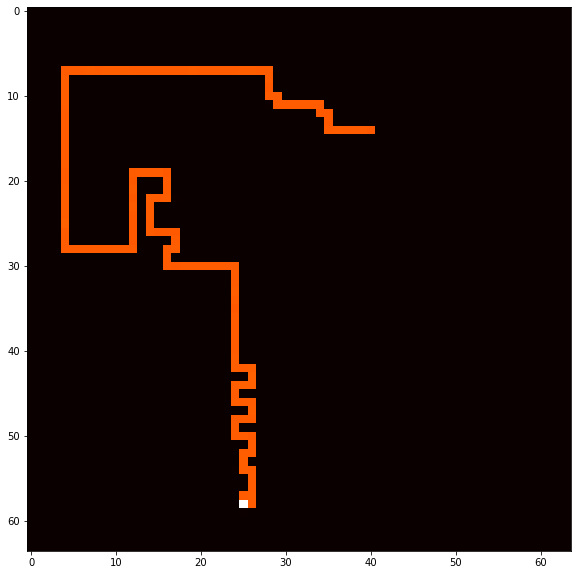

In [74]:
plt.figure(figsize=(10,10))
plt.imshow(prob_2,cmap='hot')

Netrunner has reached android 🏆
Number of steps 151


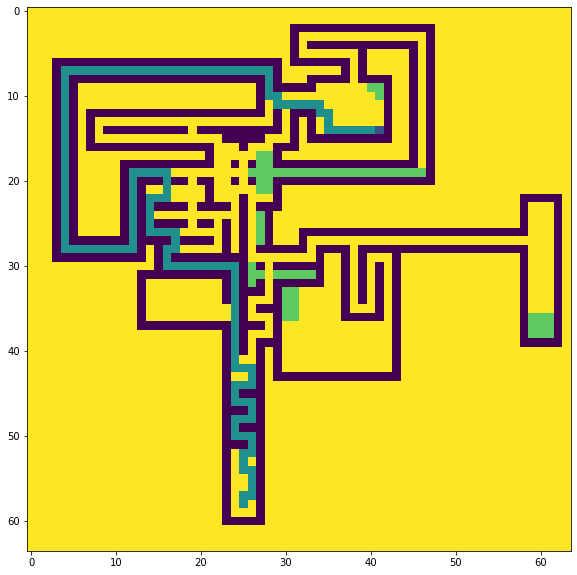

In [75]:
print_route(env,qtable)

# With Door

In [84]:
props = {
'total_episodes' : 100000,
'learning_rate' : 0.7,
'max_steps' : 8000,
'gamma' : 0.95,
'epsilon' : 1.0,
'max_epsilon' : 1.0,
'min_epsilon' : 0.01,
'decay_rate' : 0.00003
}

In [85]:
env = Env('door')

# Q-learning

In [86]:
rewards,rewards_sum,qtable = train_agent_Q(env,props,door=True)

Progress: [####################] 100.0%


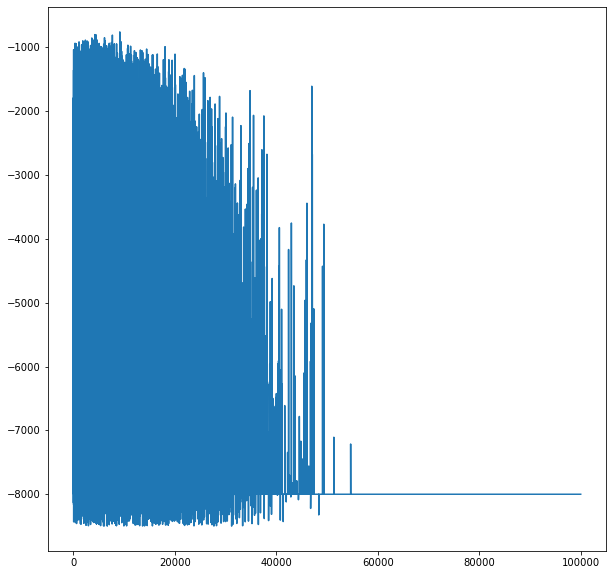

In [87]:
plt.figure(figsize=(10,10))
plt.plot(rewards)

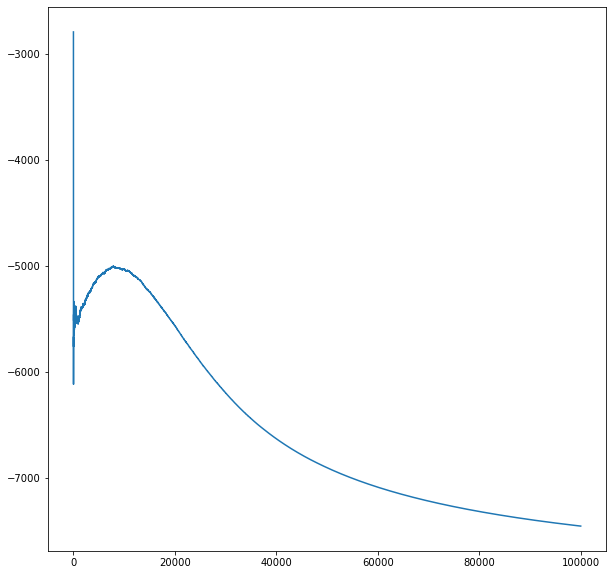

In [88]:
plt.figure(figsize=(10,10))
plt.plot(rewards_sum)